# K-Means & PCA

### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 204.2MB 62kB/s 
     |████████████████████████████████| 204kB 44.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=2f9e15d68af85f7c4b82d49ddb7e8bb4b14f7bd4de2d7606f91a17627d2c40e0
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

Now we import some of the libraries usually needed by our workload.





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [ ]:
spark

### Data Preprocessing

In this Colab, rather than downloading a file from Google Drive, we will load a famous machine learning dataset, the [Breast Cancer Wisconsin dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), using the ```scikit-learn``` datasets loader.

In [ ]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()

For convenience, given that the dataset is small, we first construct a Pandas dataframe, tune the schema, and then convert it into a Spark dataframe.

In [ ]:
pd_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df = spark.createDataFrame(pd_df)

def set_df_columns_nullable(spark, df, column_list, nullable=False):
    for struct_field in df.schema:
        if struct_field.name in column_list:
            struct_field.nullable = nullable
    df_mod = spark.createDataFrame(df.rdd, df.schema)
    return df_mod

df = set_df_columns_nullable(spark, df, df.columns)
df = df.withColumn('features', array(df.columns))
vectors = df.rdd.map(lambda row: Vectors.dense(row.features))

df.printSchema()

root
 |-- mean radius: double (nullable = false)
 |-- mean texture: double (nullable = false)
 |-- mean perimeter: double (nullable = false)
 |-- mean area: double (nullable = false)
 |-- mean smoothness: double (nullable = false)
 |-- mean compactness: double (nullable = false)
 |-- mean concavity: double (nullable = false)
 |-- mean concave points: double (nullable = false)
 |-- mean symmetry: double (nullable = false)
 |-- mean fractal dimension: double (nullable = false)
 |-- radius error: double (nullable = false)
 |-- texture error: double (nullable = false)
 |-- perimeter error: double (nullable = false)
 |-- area error: double (nullable = false)
 |-- smoothness error: double (nullable = false)
 |-- compactness error: double (nullable = false)
 |-- concavity error: double (nullable = false)
 |-- concave points error: double (nullable = false)
 |-- symmetry error: double (nullable = false)
 |-- fractal dimension error: double (nullable = false)
 |-- worst radius: double (nullable

With the next cell, we build the two datastructures that we will be using throughout this Colab:


*   ```features```, a dataframe of Dense vectors, containing all the original features in the dataset;
*   ```labels```, a series of binary labels indicating if the corresponding set of features belongs to a subject with breast cancer, or not.



In [ ]:
from pyspark.ml.linalg import Vectors
features = spark.createDataFrame(vectors.map(Row), ["features"])
labels = pd.Series(breast_cancer.target)

#**KMeans on Original Features:**



If you run successfully the Setup and Data Preprocessing stages, you are now ready to cluster the data with the [K-means](https://spark.apache.org/docs/latest/ml-clustering.html) algorithm included in MLlib (Spark's Machine Learning library).
Set the ```k``` parameter, fit the model, and the compute the [Silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) (i.e., a measure of quality of the obtained clustering).  

**IMPORTANT:** use the MLlib implementation of the Silhouette score (via ```ClusteringEvaluator```).

In [ ]:
# Applying KMeans on actual features
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(features)

predictions = model.transform(features)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# showing the predicted centers
centers = model.clusterCenters()
centers

Silhouette with squared euclidean distance = 0.8342904262826145


[array([1.25562991e+01, 1.85703653e+01, 8.11234703e+01, 4.96061872e+02,
        9.48844977e-02, 9.10998174e-02, 6.24377642e-02, 3.34325434e-02,
        1.78057991e-01, 6.34540183e-02, 3.04190868e-01, 1.21515320e+00,
        2.15288059e+00, 2.37852922e+01, 7.17326256e-03, 2.34746895e-02,
        2.87455128e-02, 1.06363242e-02, 2.06135799e-02, 3.74750297e-03,
        1.40439018e+01, 2.47095434e+01, 9.19375114e+01, 6.19647945e+02,
        1.29959110e-01, 2.23311758e-01, 2.19214947e-01, 9.13298425e-02,
        2.83553653e-01, 8.32819406e-02]),
 array([1.93799237e+01, 2.16945802e+01, 1.28231298e+02, 1.18592977e+03,
        1.01294580e-01, 1.48612977e-01, 1.76939466e-01, 1.00698779e-01,
        1.91539695e-01, 6.06029008e-02, 7.42803817e-01, 1.22253817e+00,
        5.25058015e+00, 9.56781679e+01, 6.59868702e-03, 3.21766947e-02,
        4.24197710e-02, 1.56739847e-02, 2.03039695e-02, 3.95338931e-03,
        2.37094656e+01, 2.89126718e+01, 1.58496183e+02, 1.75302290e+03,
        1.40424733e-01

#**Finding WSS using builtin and custom method:**

Computing the within cluster sum of squares (WSS) using custom method in Spark. Note that the score can be be obtained using the `summary.trainingCost` method of the fitted kmeans model.

In [ ]:
# getting actual WSSE cost
print("actual ",model.summary.trainingCost)

actual  77943099.87829885


In [ ]:
# custom function to calculate WSSE
def calculate_WSSE(feats, preds):
  errlst = []
  for feat, lbl in zip(feats, preds):
    if lbl == 0:
      errlst.append(np.sum((feat-centers[0])**2))
    else:
      errlst.append(np.sum((feat-centers[1])**2))
  return np.sum(errlst)

In [ ]:
# getting features and predictions array in order to iterate for calculating WSSE
feat_arr = predictions.select(predictions.features).collect()
preds = predictions.select(predictions.prediction).collect()

WSSE = calculate_WSSE(feat_arr, preds)
print("Within Cluster Sum of Squared Error = " + str(WSSE))

Within Cluster Sum of Squared Error = 854276901.2461549


#**Checking Correctly Classified Samples:**

**Take** the predictions produced by K-means, and compare them with the ```labels``` variable (i.e., the ground truth from our dataset).  

Compute how many data points in the dataset have been clustered correctly (i.e., positive cases in one cluster, negative cases in the other).

*HINT*: you can use ```np.count_nonzero(series_a == series_b)``` to quickly compute the element-wise comparison of two series.

**IMPORTANT**: K-means is a clustering algorithm, so it will not output a label for each data point, but just a cluster identifier!  As such, label ```0``` does not necessarily match the cluster identifier ```0```.


In [ ]:
# checking if cluster identifier and labels are the same or not
print(labels[0])
df.show(n =1)
predictions.show(n=1, truncate = False)

0
+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+--------------------+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst concave points|worst symmetry|worst fractal dimension|    

In [ ]:
cluster_df = predictions.toPandas()    
cluster_df.head()

,features,prediction
0,"[17.99, 10.38, 122.8, 1001.0, 0.1184, 0.2776, ...",1
1,"[20.57, 17.77, 132.9, 1326.0, 0.08474, 0.07864...",1
2,"[19.69, 21.25, 130.0, 1203.0, 0.1096, 0.1599, ...",1
3,"[11.42, 20.38, 77.58, 386.1, 0.1425, 0.2839, 0...",0
4,"[20.29, 14.34, 135.1, 1297.0, 0.1003, 0.1328, ...",1



---
the above output shows that predicted cluster labels are flipped, i.e cluster 1 is label 0 and cluster 0 is label 1

---



In [ ]:
np.count_nonzero(labels!=cluster_df.prediction)

486

#**Applying PCA on the data:**

Now perform dimensionality reduction on the ```features``` using the [PCA](https://spark.apache.org/docs/latest/ml-features.html#pca) statistical procedure, available as well in MLlib.

Set the ```k``` parameter to **2**, effectively reducing the dataset size of a **15X** factor.

In [ ]:
# applying PCA on actual features
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(features)

pca_features = pca_model.transform(features).select("pcaFeatures")

# renaming the column features (needed for kmeans.fit)
pca_features = pca_features.selectExpr("pcaFeatures as features")
pca_features.show(truncate=False)

+-----------------------------------------+
|features                                 |
+-----------------------------------------+
|[-2260.0138862925405,-187.9603012226368] |
|[-2368.993755782054,121.58742425815508]  |
|[-2095.6652015478608,145.11398565870087] |
|[-692.6905100570508,38.576922592081765]  |
|[-2030.2124927427062,295.2979839927924]  |
|[-888.280053576076,26.079796157025726]   |
|[-1921.082212474845,58.807572473099206]  |
|[-1074.7813350047961,31.771227808469668] |
|[-908.5784781618829,63.83075279044624]   |
|[-861.5784494075679,40.57073549705321]   |
|[-1404.559130649947,88.23218257736237]   |
|[-1524.2324408687816,-3.2630573167779793]|
|[-1734.385647746415,273.1626781511459]   |
|[-1162.9140032230355,217.63481808344613] |
|[-903.4301030498832,135.61517666084782]  |
|[-1155.8759954206848,76.80889383742165]  |
|[-1335.7294321308068,-2.4684005450356024]|
|[-1547.2640922523087,3.805675972574325]  |
|[-2714.9647651812156,-164.37610864258804]|
|[-908.2502671870876,118.2164200

#**Applynig KMeans on PCA Features:**

Now run K-means with the same parameters as above, but on the ```pcaFeatures``` produced by the PCA reduction you just executed.


In [ ]:
# applying KMeans on PCA extracted features
pca_kmeans = kmeans.fit(pca_features)

pca_preds = pca_kmeans.transform(pca_features)
pca_centers = pca_kmeans.clusterCenters()
print("Cluster Centers: ")
for center in pca_centers:
    print(center)

Cluster Centers: 
[-793.36109344  105.48246852]
[-2124.69173996   107.54465437]


#**Computing Silhouette score and checking correctly classified samples:**

Compute the Silhouette score, as well as the number of data points that have been clustered correctly.

In [ ]:
# Evaluate clustering by computing Silhouette score
pca_eval = ClusteringEvaluator()

pca_silhouette = pca_eval.evaluate(pca_preds)
print("Silhouette with squared euclidean distance = " + str(pca_silhouette))

Silhouette with squared euclidean distance = 0.8348610363444836


In [ ]:
pca_clusters = pca_preds.toPandas()
pca_clusters.head()

,features,prediction
0,"[-2260.0138862925405, -187.9603012226368]",1
1,"[-2368.993755782054, 121.58742425815508]",1
2,"[-2095.6652015478608, 145.11398565870087]",1
3,"[-692.6905100570508, 38.576922592081765]",0
4,"[-2030.2124927427062, 295.2979839927924]",1


In [ ]:
# checking if cluster identifier and labels are the same or not
print(labels[0])
pca_features.show(n =1,truncate=False)
pca_preds.show(n=1,truncate=False)

0
+----------------------------------------+
|features                                |
+----------------------------------------+
|[-2260.0138862925405,-187.9603012226368]|
+----------------------------------------+
only showing top 1 row

+----------------------------------------+----------+
|features                                |prediction|
+----------------------------------------+----------+
|[-2260.0138862925405,-187.9603012226368]|1         |
+----------------------------------------+----------+
only showing top 1 row



In [ ]:
# predicted labels are inverse, checking correctly classified samples
np.count_nonzero(labels!=pca_clusters.prediction)

486

#**Visualizing the clusters:**

Visualize the dataset by plotting a scatter plot of the two PCA components. 

There are two plots:

1) Highlighting the two **actual** labels in the dataset

2) Highlighting the two **clusters** found by K-Means in the dataset

In [ ]:
# separating actual features for plotting
pca_act_pd = pca_features.toPandas()

x_act = np.array([i[0] for i in pca_act_pd.features])
y_act = np.array([i[1] for i in pca_act_pd.features])

In [ ]:
# separating predicted features for plotting
x_pred = np.array([i[0] for i in pca_clusters.features])
y_pred = np.array([i[1] for i in pca_clusters.features])


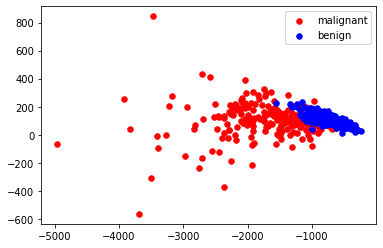

In [ ]:
# Scatterplot actual clusters

ldict = {0: 'red', 1: 'blue'}
t_names = list(breast_cancer.target_names)

fig, ax = plt.subplots()
for g in np.unique(labels):
  ix = np.where(labels == g)
  if g == 0:
    lb = t_names[0]
  else:
    lb = t_names[1]
  ax.scatter(x_act[ix], y_act[ix], c = ldict[g], label = lb, s = 30)
ax.legend()
plt.show()

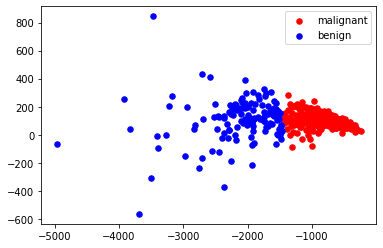

In [ ]:
# Scatterplot predicted clusters via KMeans after PCA
fig, ax = plt.subplots()
for g in np.unique(pca_clusters.prediction):
  ix = np.where(pca_clusters.prediction == g)
  if g == 0:
    lb = t_names[0]
  else:
    lb = t_names[1]
  ax.scatter(x_pred[ix], y_pred[ix], c = ldict[g], label = lb, s = 30)
ax.legend()
plt.show()

#**Running KMeans on different values of K:**

Repeat the KMeans process for K = 1 to 10. **Plotting** separately

1) the Sihouette score for each K

2) the within cluster sum of squares (WSS) for each K

In [ ]:
#running KMeans for K = 2 to 10 (K=1 throws an error)
cost = np.zeros(11)
s_score = np.zeros(11)
wsse_arr = np.zeros(11)

for k in range(2,11):
  k_kmeans = KMeans().setK(k).setSeed(1)
  mod_kmeans = k_kmeans.fit(pca_features)
  k_preds = mod_kmeans.transform(pca_features)
  s_score[k] = evaluator.evaluate(k_preds)
  wsse_arr[k] = mod_kmeans.summary.trainingCost

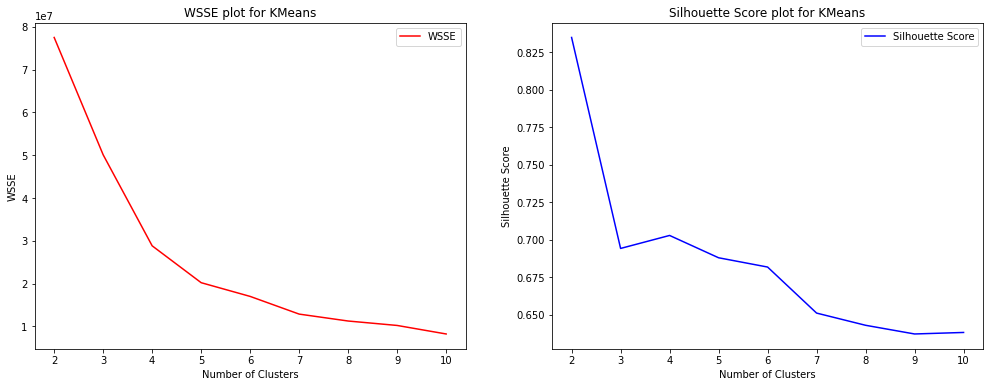

In [ ]:
#plots for WSSE and Silhouette Score
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (17,6))
ax1.plot(range(2,11),wsse_arr[2:11], label='WSSE', color = 'red')
ax1.set_title("WSSE plot for KMeans")
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WSSE')
ax1.legend()
ax2.plot(range(2,11),s_score[2:11], label='Silhouette Score', color = 'blue')
ax2.set_title("Silhouette Score plot for KMeans")
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.legend()